In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /private/var/folders/vv/724l22hd60jg6yswb04zjf6c0000gn/T/pip-req-build-3pe1xg7t
  Running command git clone -q https://github.com/tensorflow/docs /private/var/folders/vv/724l22hd60jg6yswb04zjf6c0000gn/T/pip-req-build-3pe1xg7t
  Using cached https://files.pythonhosted.org/packages/c3/88/97eef84f48fa04fbd6750e62dcceafba6c63c81b7ac1420856c8dcc0a3f9/astor-0.8.1-py2.py3-none-any.whl
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-cp37-none-any.whl size=151744 sha256=89bbc6e66679643fdb04f8dc00dcfb6160686d0773987684effc0959b9e10de4
  Stored in directory: /private/var/folders/vv/724l22hd60jg6yswb04zjf6c0000gn/T/pip-ephem-wheel-cache-as9hh792/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
logdir

PosixPath('/var/folders/vv/724l22hd60jg6yswb04zjf6c0000gn/T/tmpwe2c0ftp/tensorboard_logs')

In [6]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816417792/2816407858 [==============================] - 330s 0us/step


In [7]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [40]:
def pack_row(*row):
    #print(len(row))
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

In [41]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


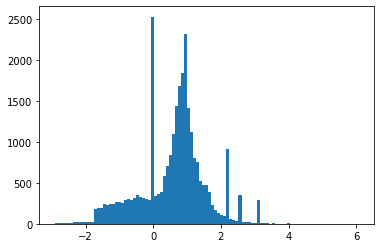

In [50]:
i = 0
for features,label in packed_ds.batch(1000).take(1):
    #print(features.shape)
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [43]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [51]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [52]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [53]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [54]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

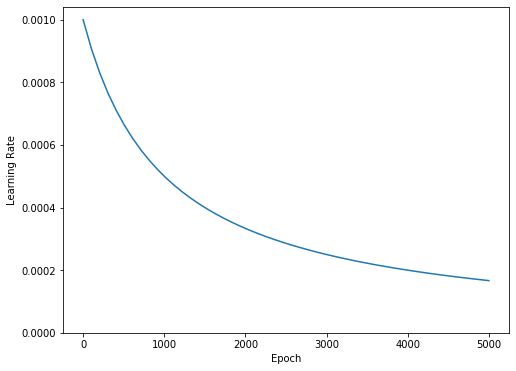

In [55]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [56]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [61]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    binary_crossentropy_metric = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, name='binary_crossentropy')
    model.compile(optimizer=optimizer,
                  loss=loss_fn,
                  metrics=[binary_crossentropy_metric, 'accuracy'])
    
    model.summary()
    
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

In [62]:
size_histories = {}

In [64]:
tiny_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1)
])

In [65]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4692,  binary_crossentropy:0.7778,  loss:0.7778,  val_accuracy:0.4550,  val_binary_crossentropy:0.7484,  val_loss:0.7484,  
....................................................................................................
Epoch: 100, accuracy:0.5829,  binary_crossentropy:0.6314,  loss:0.6314,  val_accuracy:0.5980,  val_binary_crossentropy:0.6239,  val_loss:0.6239,  
............................................................

(0.5, 0.7)

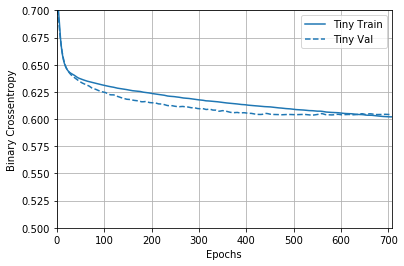

In [66]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [68]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(1)
])

In [69]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4844,  binary_crossentropy:0.7390,  loss:0.7390,  val_accuracy:0.4430,  val_binary_crossentropy:0.7359,  val_loss:0.7359,  
....................................................................................................
Epoch: 100, accuracy:0.6157,  binary_crossentropy:0.6148,  loss:0.6148,  

In [72]:
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(1)
])
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               14848     
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dense_9 (Dense)             (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5159,  binary_crossentropy

(0.5, 0.7)

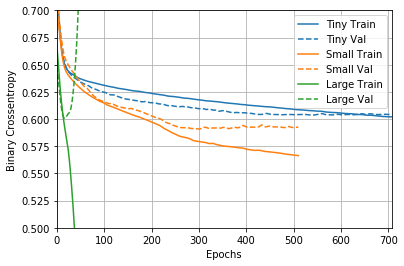

In [73]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

Text(0.5, 0, 'Epochs [Log Scale]')

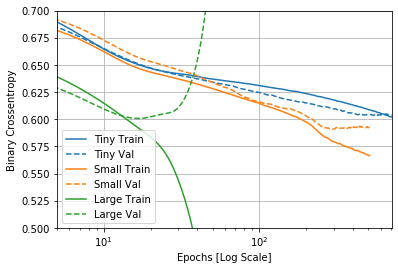

In [74]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [75]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

In [76]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/var/folders/vv/724l22hd60jg6yswb04zjf6c0000gn/T/tmpwe2c0ftp/tensorboard_logs/regularizers/Tiny')

In [78]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [81]:
l2_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    tf.keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               14848     
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5000,  binary_crossentropy

(0.5, 0.7)

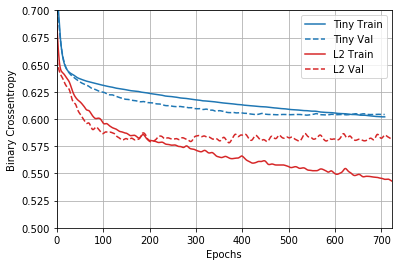

In [82]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [84]:
dropout_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 512)              

(0.5, 0.7)

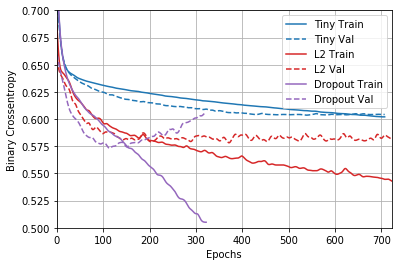

In [85]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [88]:
combined_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 512)              

(0.5, 0.7)

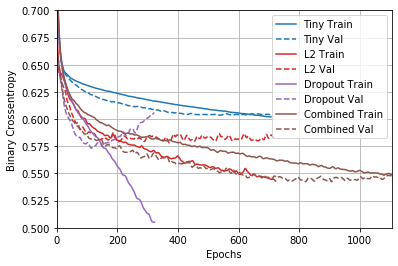

In [89]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [90]:
%tensorboard --logdir {logdir}/regularizers